# Convolutional Autoencoders and Denoising Autoencoders on Fashion‑MNIST

**Author:** Gabriel Lucky Lotanna  
**Student ID:** 24070357  

This notebook trains a convolutional autoencoder and a convolutional denoising autoencoder on the Fashion‑MNIST dataset.
All figures used in my written report are generated from this notebook. I added personal comments so it is easy to follow
what I am doing and why.

Github Repository
https://github.com/gabriel2lucky1990/fashionmnist-autoencoder-tutorial.git

## 1. Imports, configuration and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, models
from sklearn.decomposition import PCA

# I set a random seed so that my results are reasonably reproducible.
np.random.seed(42)

# Load Fashion‑MNIST (train and test splits)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Convert to float32 and normalise to [0,1] because neural networks train better on scaled data.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add a channel dimension because convolutional layers expect (H, W, C).
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print('Train shape:', x_train.shape)
print('Test shape:', x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


## 2. Figure 1 – Sample Fashion‑MNIST images

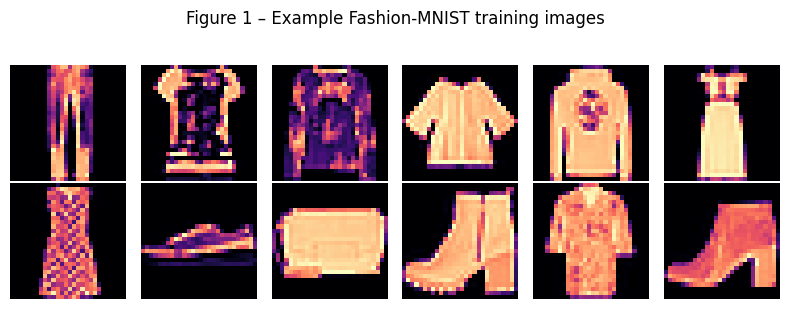

In [2]:
# Here I quickly visualise some random training images so I remember what the dataset looks like.
plt.figure(figsize=(8, 3))
for i in range(12):
    idx = np.random.randint(0, x_train.shape[0])
    plt.subplot(2, 6, i + 1)
    plt.imshow(x_train[idx].squeeze(), cmap='magma')
    plt.axis('off')
plt.suptitle('Figure 1 – Example Fashion‑MNIST training images', y=1.02)
plt.tight_layout()
plt.savefig("figure_X.png", dpi=300, bbox_inches='tight')
plt.show()

## 3. Convolutional autoencoder architecture

In [3]:
# In this cell I build a small convolutional autoencoder.
# I chose a 2‑level encoder/decoder: deep enough to learn structure but still light enough for this coursework.

input_shape = (28, 28, 1)
latent_channels = 64  # number of channels in the latent feature map

# Encoder
inputs = layers.Input(shape=input_shape, name='input_image')
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='enc_conv1')(inputs)
x = layers.MaxPooling2D((2, 2), padding='same', name='enc_pool1')(x)  # 14x14
x = layers.Conv2D(latent_channels, (3, 3), activation='relu', padding='same', name='enc_conv2')(x)
x = layers.MaxPooling2D((2, 2), padding='same', name='enc_pool2')(x)  # 7x7

latent = x  # I keep the 7x7x64 tensor as my latent representation.

encoder = models.Model(inputs, latent, name='encoder')

# Decoder – I mirror the encoder using upsampling layers.
y = layers.Conv2D(latent_channels, (3, 3), activation='relu', padding='same', name='dec_conv1')(latent)
y = layers.UpSampling2D((2, 2), name='dec_upsample1')(y)  # 14x14
y = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='dec_conv2')(y)
y = layers.UpSampling2D((2, 2), name='dec_upsample2')(y)  # 28x28
outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output_image')(y)

autoencoder = models.Model(inputs, outputs, name='conv_autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()  # I like to inspect the shapes to be sure the architecture is correct.

Model: "conv_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling2D)        │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsample1 (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsample2 (UpSampling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Training the convolutional autoencoder

In [4]:
# I train the basic convolutional autoencoder to reconstruct the clean images.
# 20 epochs is a good compromise between training time and reconstruction quality for Fashion‑MNIST.

history_basic = autoencoder.fit(
    x_train, x_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0513 - val_loss: 0.0133
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0123 - val_loss: 0.0103
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0101 - val_loss: 0.0089
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━

## 5. Figure 2 – Basic autoencoder training and validation loss

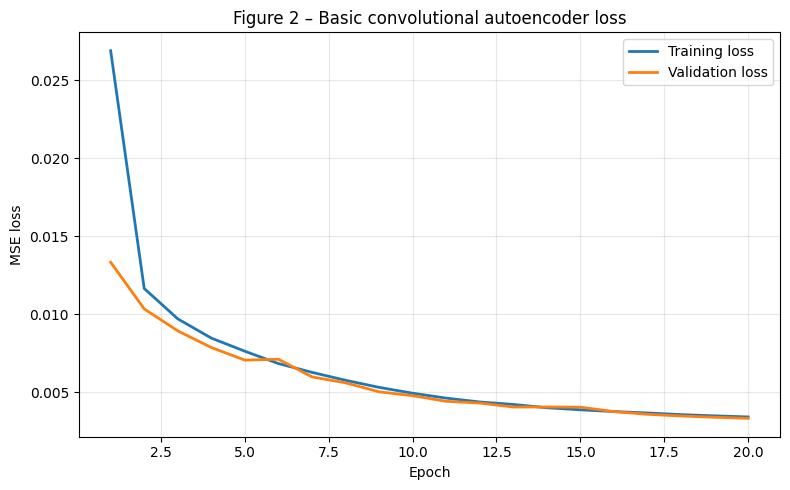

In [5]:
# Here I plot the loss curves. I want them to look clean and similar to plots in ML papers.

plt.figure(figsize=(8, 5))
epochs = range(1, len(history_basic.history['loss']) + 1)
plt.plot(epochs, history_basic.history['loss'], label='Training loss', linewidth=2)
plt.plot(epochs, history_basic.history['val_loss'], label='Validation loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Figure 2 – Basic convolutional autoencoder loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figure_X.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. Figures 3 and 4 – Reconstructions and reconstruction‑error distribution

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


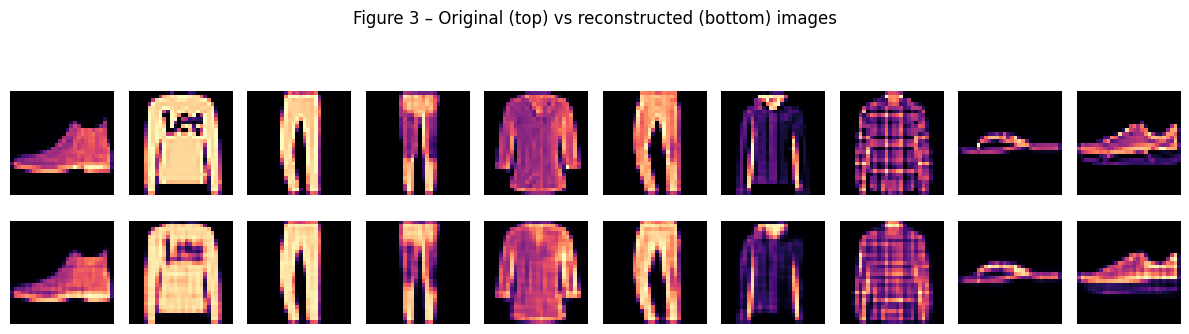

In [6]:
# I now inspect how well the basic autoencoder reconstructs test images.
decoded_test_basic = autoencoder.predict(x_test)

# Figure 3 – original vs reconstructed images
n = 10  # number of image pairs to show
plt.figure(figsize=(12, 3.5))
for i in range(n):
    # Top row: original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='magma')
    plt.axis('off')

for i in range(n):
    # Bottom row: reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test_basic[i].squeeze(), cmap='magma')
    plt.axis('off')

plt.suptitle('Figure 3 – Original (top) vs reconstructed (bottom) images', y=1.02)
plt.tight_layout()
plt.savefig("figure_X.png", dpi=300, bbox_inches='tight')
plt.show()



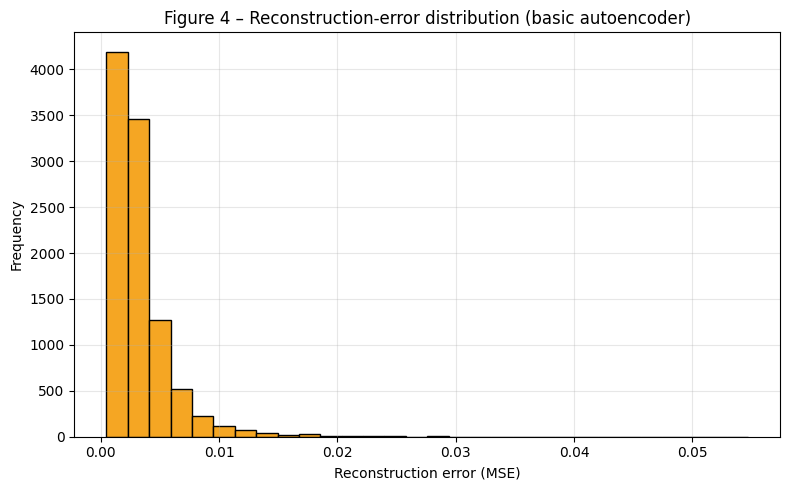

In [7]:
# Figure 4 – reconstruction‑error histogram for the basic autoencoder
x_test_flat = x_test.reshape((x_test.shape[0], -1))
decoded_flat_basic = decoded_test_basic.reshape((decoded_test_basic.shape[0], -1))
recon_errors_basic = np.mean((x_test_flat - decoded_flat_basic) ** 2, axis=1)

plt.figure(figsize=(8, 5))
plt.hist(recon_errors_basic, bins=30, color='#f5a623', edgecolor='black')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Frequency')
plt.title('Figure 4 – Reconstruction‑error distribution (basic autoencoder)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figure_X.png", dpi=300, bbox_inches='tight')
plt.show()

## 7. Convolutional denoising autoencoder

In [8]:
# Next I build a convolutional denoising autoencoder.
# Here the model receives noisy images as input but is trained to reproduce the clean images.

noise_factor = 0.4  # I picked 0.4 so the corruption is clearly visible but not completely destroying the image.
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train + noise, 0.0, 1.0)

noise_test = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test + noise_test, 0.0, 1.0)

# Build the denoising autoencoder with a similar architecture.
inputs_dn = layers.Input(shape=(28, 28, 1), name='noisy_input')
z = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs_dn)
z = layers.MaxPooling2D((2, 2), padding='same')(z)
z = layers.Conv2D(latent_channels, (3, 3), activation='relu', padding='same')(z)
z = layers.MaxPooling2D((2, 2), padding='same')(z)

z_latent = z

w = layers.Conv2D(latent_channels, (3, 3), activation='relu', padding='same')(z_latent)
w = layers.UpSampling2D((2, 2))(w)
w = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(w)
w = layers.UpSampling2D((2, 2))(w)
outputs_dn = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(w)

denoising_autoencoder = models.Model(inputs_dn, outputs_dn, name='denoising_autoencoder')
denoising_autoencoder.compile(optimizer='adam', loss='mse')

denoising_autoencoder.summary()

Model: "denoising_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noisy_input (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Training the denoising autoencoder

In [9]:
# I now train the denoising autoencoder using (noisy -> clean) image pairs.

history_denoise = denoising_autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0559 - val_loss: 0.0199
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0192 - val_loss: 0.0176
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0173 - val_loss: 0.0165
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0164 - val_loss: 0.0159
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0157 - val_loss: 0.0152
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0146 - val_loss: 0.0143
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

## 9. Figure 5 – Denoising autoencoder loss curves

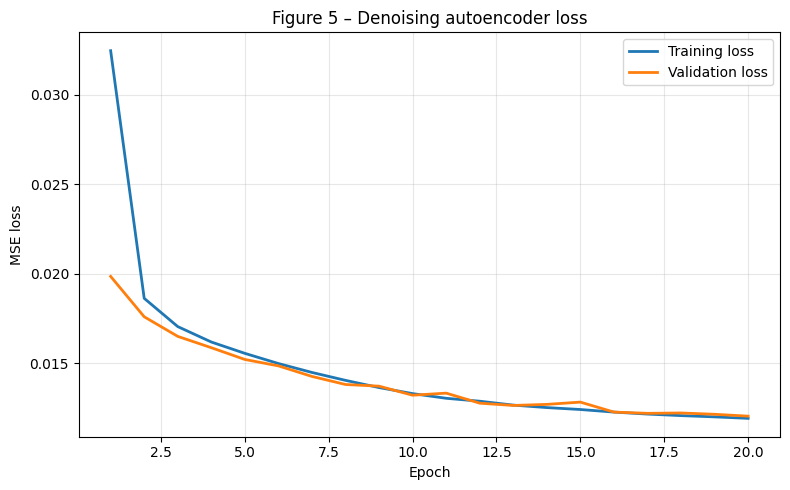

In [10]:
plt.figure(figsize=(8, 5))
epochs_dn = range(1, len(history_denoise.history['loss']) + 1)
plt.plot(epochs_dn, history_denoise.history['loss'], label='Training loss', linewidth=2)
plt.plot(epochs_dn, history_denoise.history['val_loss'], label='Validation loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Figure 5 – Denoising autoencoder loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figure_X.png", dpi=300, bbox_inches='tight')
plt.show()

## 10. Figure 6 – Noisy vs clean vs denoised images

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


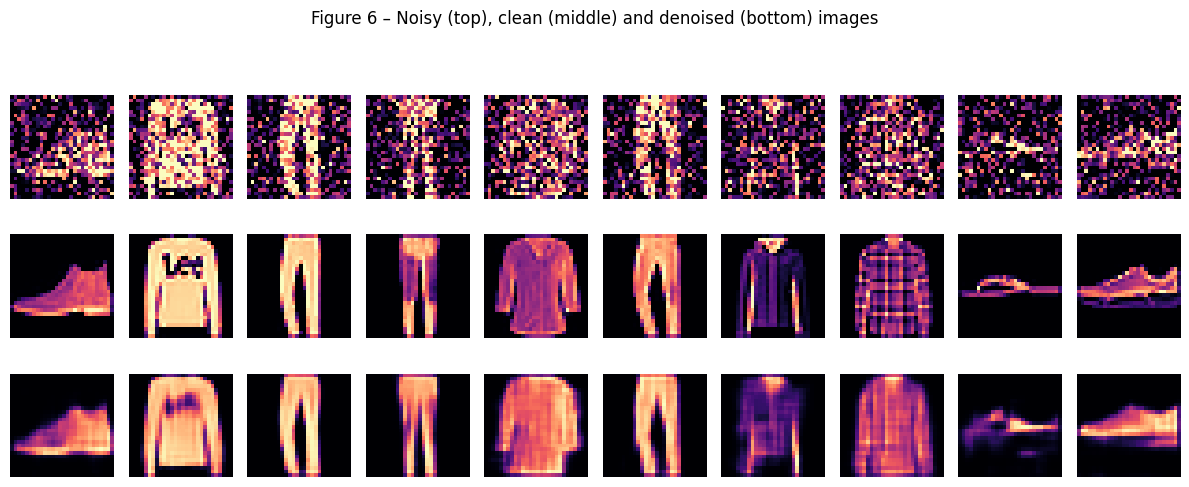

In [11]:
# To evaluate denoising visually, I plot triplets: noisy input, clean target, and denoised output.

decoded_test_denoise = denoising_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(12, 5))
for i in range(n):
    # Top row: noisy inputs
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='magma')
    plt.axis('off')
for i in range(n):
    # Middle row: clean images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i].squeeze(), cmap='magma')
    plt.axis('off')
for i in range(n):
    # Bottom row: denoised outputs
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_test_denoise[i].squeeze(), cmap='magma')
    plt.axis('off')

plt.suptitle('Figure 6 – Noisy (top), clean (middle) and denoised (bottom) images', y=1.02)
plt.tight_layout()
plt.savefig("figure_X.png", dpi=300, bbox_inches='tight')
plt.show()

## 11. Figure 7 – Latent space projection and denoising reconstruction errors

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


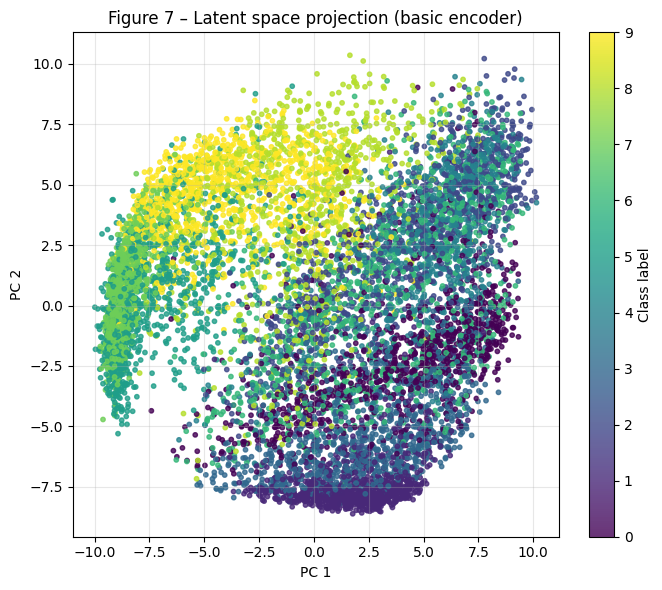

In [12]:
# Finally I explore the latent space of the basic encoder and the reconstruction errors of the denoising model.

# Latent space projection using PCA on the basic encoder's latent features.
latent_maps = encoder.predict(x_test)
latent_flat = latent_maps.reshape((latent_maps.shape[0], -1))

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_flat)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, cmap='viridis', s=10, alpha=0.8)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Figure 7 – Latent space projection (basic encoder)')
cbar = plt.colorbar(scatter)
cbar.set_label('Class label')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figure_X.png", dpi=300, bbox_inches='tight')
plt.show()



11. **Figure** 8 shows a histogram overlaid with a kernel density estimate (KDE), providing a smooth approximation of the reconstruction-error distribution...”


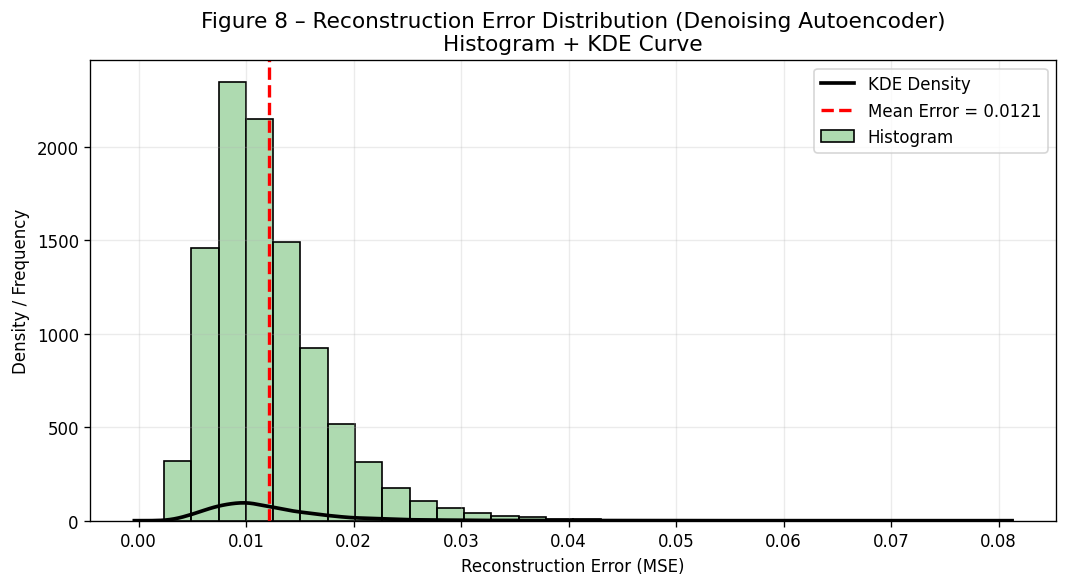

In [13]:

# FIGURE 8 – Reconstruction Error Distribution (Denoising AE)
# Histogram + KDE curve (Research Style)

import seaborn as sns

# Flatten denoised outputs for error calculation
decoded_flat_dn = decoded_test_denoise.reshape((decoded_test_denoise.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

# Compute per-image reconstruction error (MSE)
recon_errors_dn = np.mean((x_test_flat - decoded_flat_dn) ** 2, axis=1)

plt.figure(figsize=(9, 5), dpi=120)

# Histogram (semi-transparent)
sns.histplot(
    recon_errors_dn,
    bins=30,
    kde=False,
    color='#4CAF50',
    edgecolor='black',
    alpha=0.45,
    label='Histogram'
)

# KDE curve
sns.kdeplot(
    recon_errors_dn,
    color='black',
    linewidth=2.2,
    label='KDE Density'
)

# Mean error vertical line
plt.axvline(
    np.mean(recon_errors_dn),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean Error = {np.mean(recon_errors_dn):.4f}"
)

plt.title("Figure 8 – Reconstruction Error Distribution (Denoising Autoencoder)\nHistogram + KDE Curve", fontsize=13)
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Density / Frequency")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig("figure_X.png", dpi=300, bbox_inches='tight')
plt.show()
